In [1]:
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, LassoLarsCV, Lars
import pandas as pd
from sklearn import model_selection
from sklearn import preprocessing
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn_pandas import gen_features
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from time import time
from scipy.stats import randint as sp_randint
import numpy as np

In [28]:
lr = LinearRegression(fit_intercept=False)
regr = Ridge(fit_intercept=False) # no need for intercept since our data is centered

In [3]:
scores = pd.read_csv('soretdScores.csv', lineterminator='\n')

In [4]:
data = pd.read_csv('motionData.csv', lineterminator='\n')
data.rename(columns={"FFPType\r": "FFPType"},inplace=True)

In [5]:
FEATURES = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"]
FEATURESALL = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType"]

In [6]:
EMOSCORES = ["happier_mu", "sadder_mu", "angrier_mu"]
EMOCONFIDENCE_INV = ["happier_sigma", "sadder_sigma", "angrier_sigma"]
min_confidence = 25/3 # true skill base confidence: http://trueskill.org/
EMOWTS = ["happier_wt", "sadder_wt", "angrier_wt"]

In [7]:
emotionid = 0;

In [8]:
mapper = DataFrameMapper([
...     (["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"], preprocessing.StandardScaler()),
...     (['FFPType'], preprocessing.OneHotEncoder())], input_df = True, sparse = True) # may want to set sparse false for Lars regression which expects a dense array

In [9]:
transformedData = mapper.fit_transform(data.copy())

In [10]:
WTS= {'happier_wt':(1.5-(scores[EMOCONFIDENCE_INV[0]]/min_confidence)).values,
                   'sadder_wt':(1.5-(scores[EMOCONFIDENCE_INV[1]]/min_confidence)).values,
                'angrier_wt':(1.5-(scores[EMOCONFIDENCE_INV[2]]/min_confidence)).values}
WTS_df = pd.DataFrame(WTS,scores.index)
scores_WTS = pd.concat([scores, WTS_df], axis = 1)

In [11]:
 X_train, X_test, y_train, y_test = model_selection.train_test_split(transformedData, scores_WTS, test_size=0.2, random_state=42)

In [12]:
# use a full grid over all parameters
param_grid = {"alpha": [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]}

# run grid search
grid_search = GridSearchCV(regr, param_grid=param_grid, cv=10, n_jobs = -1)
start = time()
grid_search.fit(X_train, y_train[EMOSCORES[emotionid]], sample_weight=y_train[EMOWTS[emotionid]])

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
print(grid_search.cv_results_)

GridSearchCV took 6.91 seconds for 9 candidate parameter settings.
{'split0_train_score': array([ 0.41453497,  0.41453506,  0.41453583,  0.41454352,  0.41462006,
        0.41534573,  0.41877114,  0.36319207,  0.17801067]), 'mean_train_score': array([ 0.41684066,  0.41684075,  0.41684154,  0.41684943,  0.41692794,
        0.41767182,  0.42113454,  0.36321106,  0.17149478]), 'param_alpha': masked_array(data = [0 1e-05 0.0001 0.001 0.01 0.1 1 5 10],
             mask = [False False False False False False False False False],
       fill_value = ?)
, 'split7_train_score': array([ 0.40843872,  0.40843881,  0.4084396 ,  0.40844751,  0.40852622,
        0.40927258,  0.41280521,  0.35594569,  0.16655293]), 'split1_train_score': array([ 0.40836613,  0.40836623,  0.40836705,  0.4083753 ,  0.40845738,
        0.40923529,  0.4128831 ,  0.35279923,  0.15323925]), 'split9_train_score': array([ 0.4147987 ,  0.41479879,  0.41479957,  0.41480733,  0.4148846 ,
        0.41561562,  0.41891324,  0.3595792

In [13]:
grid_search.best_estimator_ 

Ridge(alpha=1, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [14]:
grid_search.best_score_

0.37489990110748711

In [15]:
grid_search.best_params_

{'alpha': 1}

In [16]:
regrTest = RidgeCV(alphas=[0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10], fit_intercept = False, cv = 10)
regrTest.fit(X_train, y_train[EMOSCORES[emotionid]],sample_weight=y_train[EMOWTS[emotionid]])
# this gives same result as grid search..

RidgeCV(alphas=[0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10], cv=10,
    fit_intercept=False, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [16]:
# ytestCV_pred=regrTest.predict(X_test)
# ytrainCV_pred=regrTest.predict(X_train)

ytestCV_pred=grid_search.best_estimator_.predict(X_test)
ytrainCV_pred=grid_search.best_estimator_.predict(X_train)

In [18]:
print("Mean squared error wtd CV (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytestCV_pred,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd CV (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytestCV_pred,sample_weight=y_test[EMOWTS[emotionid]]))

Mean squared error wtd CV (test): 18.48
Variance score wtd CV (test): 0.4759


In [19]:
bestEstimator_testmse = mean_squared_error( y_test[EMOSCORES[emotionid]],ytestCV_pred,sample_weight=y_test[EMOWTS[emotionid]])
bestEstimator_testr2 = r2_score( y_test[EMOSCORES[emotionid]],ytestCV_pred,sample_weight=y_test[EMOWTS[emotionid]])

bestEstimator_trainmse = mean_squared_error( y_train[EMOSCORES[emotionid]],ytrainCV_pred,sample_weight=y_train[EMOWTS[emotionid]])
bestEstimator_trainr2 = r2_score( y_train[EMOSCORES[emotionid]],ytrainCV_pred,sample_weight=y_train[EMOWTS[emotionid]])

save_info = pd.DataFrame()
regr_info = pd.Series(str(grid_search.best_estimator_.get_params()))

save_info['trained'] = regr_info
save_info['regressor name'] = "Ridge"
save_info['test wtd mse'] = bestEstimator_testmse
save_info['test wtd r2'] = bestEstimator_testr2
save_info['train wtd mse'] = bestEstimator_trainmse
save_info['train wtd r2'] = bestEstimator_trainr2
save_info['emotion'] = "happy"

with open('C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\regressorExperiments.csv', 'a') as f:
    save_info.to_csv(f, header=False, index=False)

In [34]:
# lasso and lassolars do worse than ridge and ridge does worse than std, linear regression!!
lasso_regr = LassoCV(alphas=[0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10], fit_intercept = False, cv = 10)
#lasso_regr = LassoLarsCV( fit_intercept = False, cv = 10)
lasso_regr.fit(X_train.toarray(), y_train[EMOSCORES[emotionid]])

ytestLassoCV_pred=lasso_regr.predict(X_test)
ytrainLassoCV_pred=lasso_regr.predict(X_train)

print("Mean squared error wtd Lasso CV (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytestLassoCV_pred,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd Lasso CV (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytestLassoCV_pred,sample_weight=y_test[EMOWTS[emotionid]]))
lasso_regr.alpha_

Mean squared error wtd Lasso CV (test): 18.63
Variance score wtd Lasso CV (test): 0.4717


C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.001

In [35]:
lasso_regr

LassoCV(alphas=[0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10], copy_X=True,
    cv=10, eps=0.001, fit_intercept=False, max_iter=1000, n_alphas=100,
    n_jobs=1, normalize=False, positive=False, precompute='auto',
    random_state=None, selection='cyclic', tol=0.0001, verbose=False)

In [36]:
bestEstimator_testmse = mean_squared_error( y_test[EMOSCORES[emotionid]],ytestLassoCV_pred,sample_weight=y_test[EMOWTS[emotionid]])
bestEstimator_testr2 = r2_score( y_test[EMOSCORES[emotionid]],ytestLassoCV_pred,sample_weight=y_test[EMOWTS[emotionid]])

bestEstimator_trainmse = mean_squared_error( y_train[EMOSCORES[emotionid]],ytrainLassoCV_pred,sample_weight=y_train[EMOWTS[emotionid]])
bestEstimator_trainr2 = r2_score( y_train[EMOSCORES[emotionid]],ytrainLassoCV_pred,sample_weight=y_train[EMOWTS[emotionid]])

save_info = pd.DataFrame()
regr_info = pd.Series(str(lasso_regr.get_params()))

save_info['trained'] = regr_info
save_info['regressor name'] = "Lasso"
save_info['test wtd mse'] = bestEstimator_testmse
save_info['test wtd r2'] = bestEstimator_testr2
save_info['train wtd mse'] = bestEstimator_trainmse
save_info['train wtd r2'] = bestEstimator_trainr2
save_info['emotion'] = "happy"

with open('C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\regressorExperiments.csv', 'a') as f:
    save_info.to_csv(f, header=False, index=False)

In [29]:
lr.fit(X_train, y_train[EMOSCORES[emotionid]],sample_weight=y_train[EMOWTS[emotionid]])

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [21]:
# ytest_pred=grid_search.best_estimator_.predict(X_test)
# ytrain_pred=grid_search.best_estimator_.predict(X_train)

In [30]:
ytest_pred_lr=lr.predict(X_test)
ytrain_pred_lr=lr.predict(X_train)

In [23]:
# print("Mean squared error wtd (test): %.2f"
#       % mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]]))
# # Explained variance score: 1 is perfect prediction
# print('Variance score wtd (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]]))

Mean squared error wtd (test): 23.29
Variance score wtd (test): 0.2164


In [31]:
print("Mean squared error LR wtd (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred_lr,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score LR wtd (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytest_pred_lr,sample_weight=y_test[EMOWTS[emotionid]]))

Mean squared error LR wtd (test): 18.26
Variance score LR wtd (test): 0.4822


In [25]:
# print("Mean squared error wtd (train): %.2f"
#       % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]]))
# # Explained variance score: 1 is perfect prediction
# print('Variance score wtd (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]]))

Mean squared error wtd (train): 25.15
Variance score wtd (train): 0.19


In [32]:
print("Mean squared error wtd LR (train): %.2f"
      % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred_lr,sample_weight=y_train[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd LR (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred_lr,sample_weight=y_train[EMOWTS[emotionid]]))

Mean squared error wtd LR (train): 20.57
Variance score wtd LR (train): 0.45


In [33]:
bestEstimator_testmse = mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred_lr,sample_weight=y_test[EMOWTS[emotionid]])
bestEstimator_testr2 = r2_score( y_test[EMOSCORES[emotionid]],ytest_pred_lr,sample_weight=y_test[EMOWTS[emotionid]])

bestEstimator_trainmse = mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred_lr,sample_weight=y_train[EMOWTS[emotionid]])
bestEstimator_trainr2 = r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred_lr,sample_weight=y_train[EMOWTS[emotionid]])

save_info = pd.DataFrame()
regr_info = pd.Series(str(lr.get_params()))

save_info['trained'] = regr_info
save_info['regressor name'] = "Linear"
save_info['test wtd mse'] = bestEstimator_testmse
save_info['test wtd r2'] = bestEstimator_testr2
save_info['train wtd mse'] = bestEstimator_trainmse
save_info['train wtd r2'] = bestEstimator_trainr2
save_info['emotion'] = "happy"

with open('C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\regressorExperiments.csv', 'a') as f:
    save_info.to_csv(f, header=False, index=False)

In [27]:
LABEL = EMOSCORES[emotionid]
predicted_name ="predicted_"+LABEL

Populating the interactive namespace from numpy and matplotlib


C:\Users\root\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


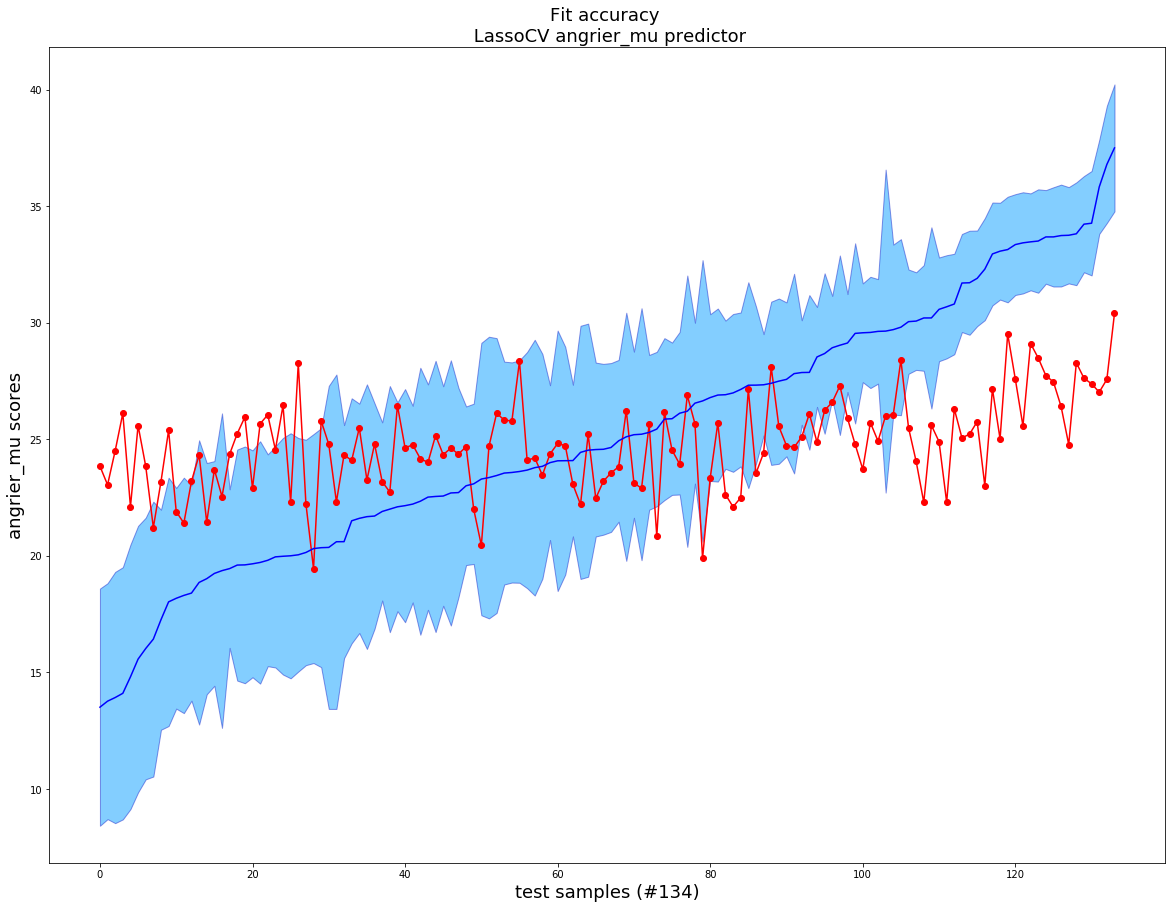

In [28]:
y_hat_LassoCVregr = pd.DataFrame(ytestLassoCV_pred, columns=[predicted_name], index=y_test[LABEL].index) 

y_all_testLassoCVregr = pd.concat([y_hat_LassoCVregr, y_test[LABEL], y_test[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_testLassoCVregr_sorted = y_all_testLassoCVregr.sort_values(EMOSCORES[emotionid],ascending=[True])


%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testLassoCVregr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testLassoCVregr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testLassoCVregr_sorted[LABEL].values-y_all_testLassoCVregr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_testLassoCVregr_sorted[LABEL].values+y_all_testLassoCVregr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testLassoCVregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n LassoCV ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

In [29]:
y_hat_regr = pd.DataFrame(ytest_pred, columns=[predicted_name], index=y_test[LABEL].index) 

y_all_testregr = pd.concat([y_hat_regr, y_test[LABEL], y_test[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_testregr_sorted = y_all_testregr.sort_values(EMOSCORES[emotionid],ascending=[True])

ytrain_hat_regr = pd.DataFrame(ytrain_pred, columns=[predicted_name], index=y_train[LABEL].index) 

y_all_trainregr = pd.concat([ytrain_hat_regr, y_train[LABEL], y_train[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_trainregr_sorted = y_all_trainregr.sort_values(EMOSCORES[emotionid],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


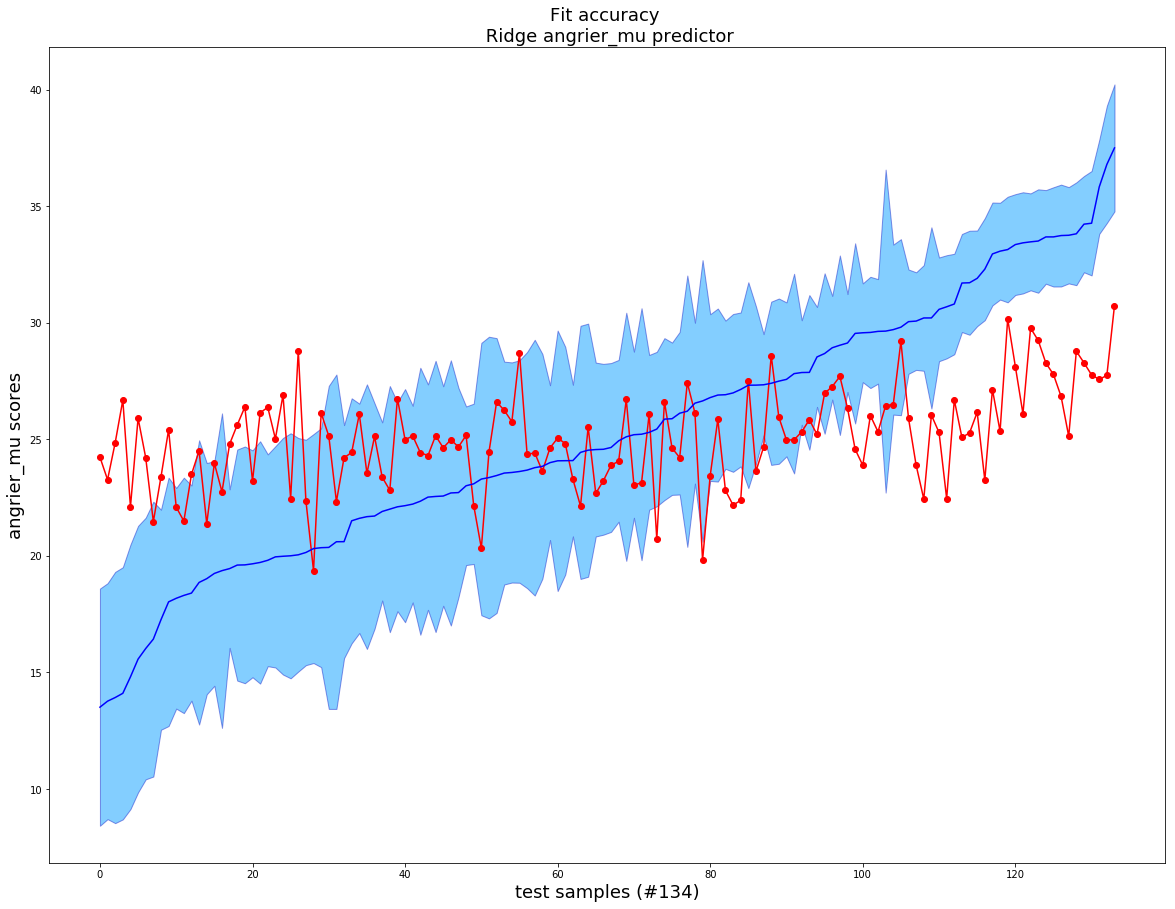

In [30]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testregr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testregr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testregr_sorted[LABEL].values-y_all_testregr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_testregr_sorted[LABEL].values+y_all_testregr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Ridge ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

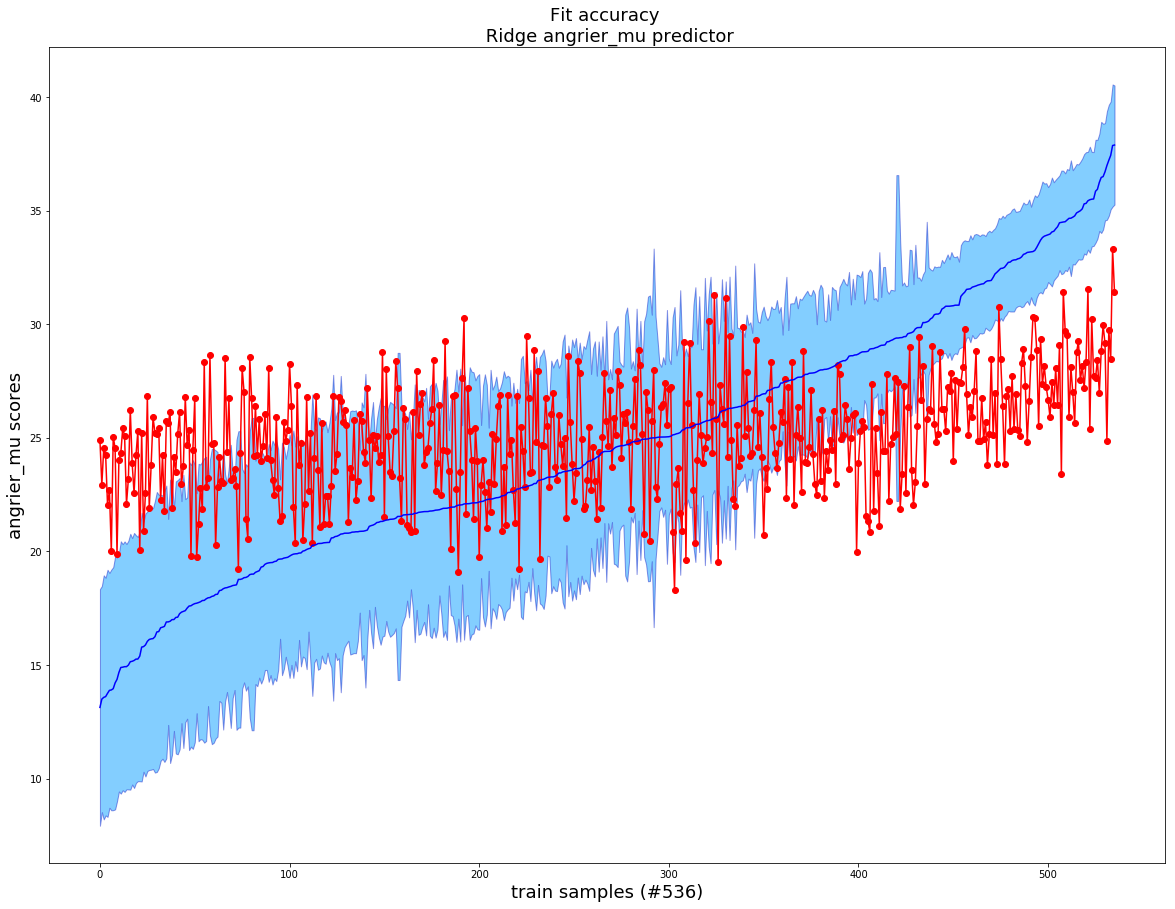

In [31]:
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_trainregr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_trainregr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_trainregr_sorted[LABEL].values-y_all_trainregr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_trainregr_sorted[LABEL].values+y_all_trainregr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_trainregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Ridge ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

In [32]:
y_hat_lr = pd.DataFrame(ytest_pred_lr, columns=[predicted_name], index=y_test[LABEL].index) 

y_all_testlr = pd.concat([y_hat_lr, y_test[LABEL], y_test[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_testlr_sorted = y_all_testlr.sort_values(EMOSCORES[emotionid],ascending=[True])

ytrain_hat_lr = pd.DataFrame(ytrain_pred_lr, columns=[predicted_name], index=y_train[LABEL].index) 

y_all_trainlr = pd.concat([ytrain_hat_lr, y_train[LABEL], y_train[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_trainlr_sorted = y_all_trainlr.sort_values(EMOSCORES[emotionid],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


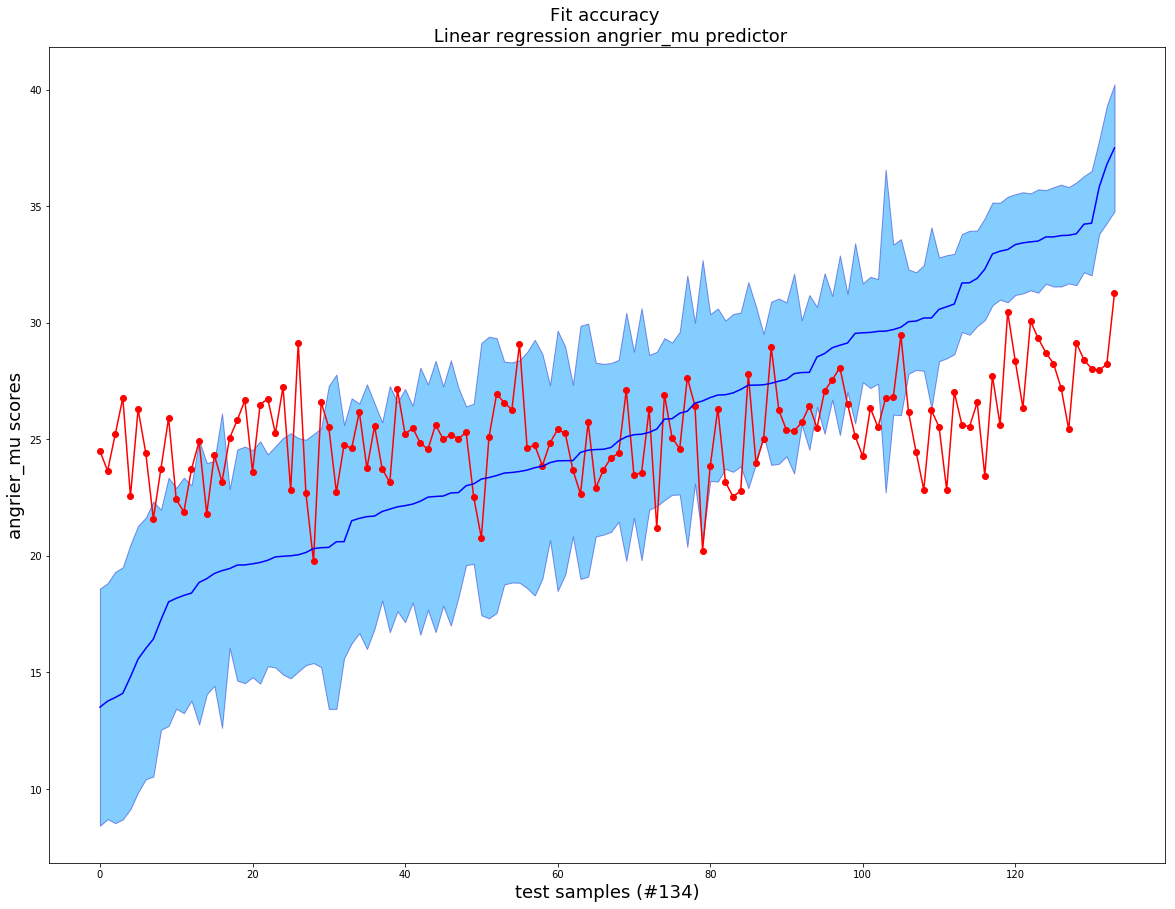

In [33]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testlr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testlr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testlr_sorted[LABEL].values-y_all_testlr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_testlr_sorted[LABEL].values+y_all_testlr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

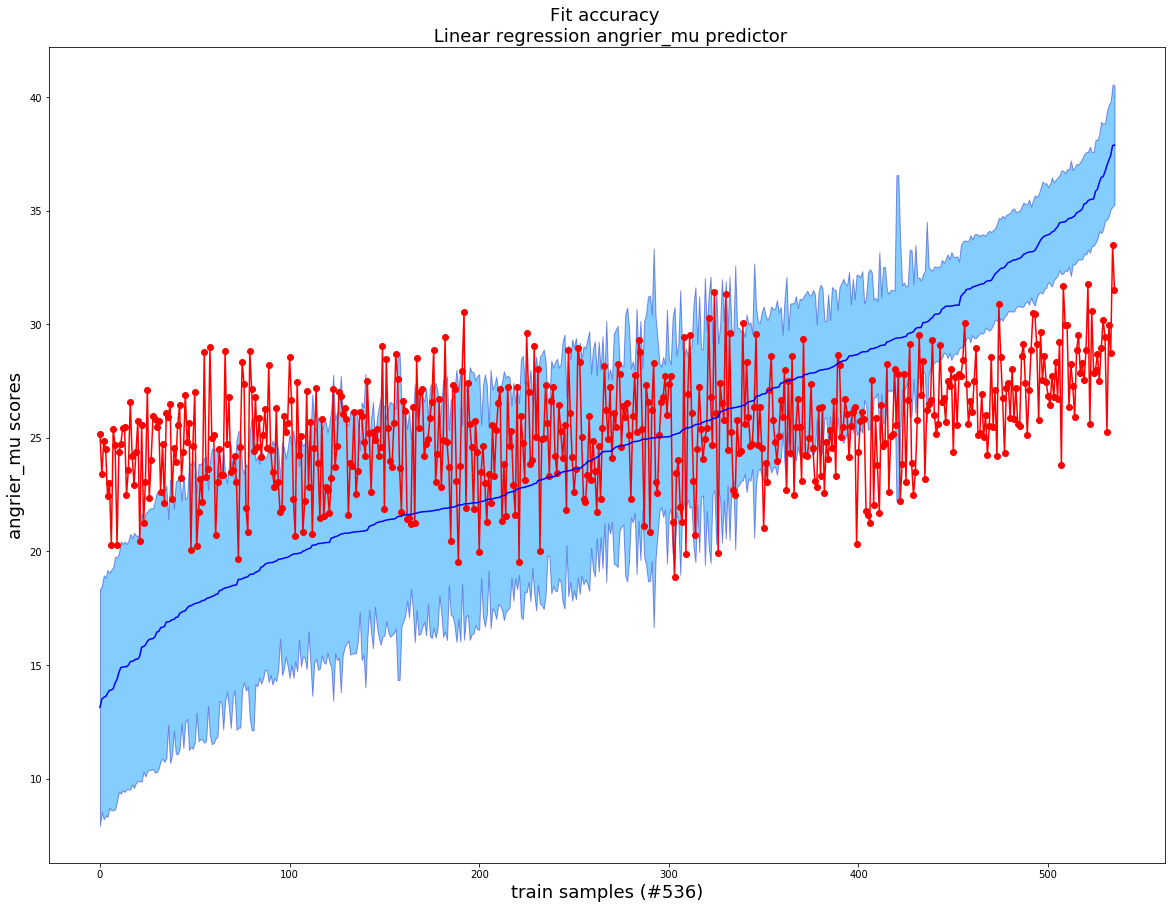

In [34]:
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_trainlr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_trainlr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_trainlr_sorted[LABEL].values-y_all_trainlr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_trainlr_sorted[LABEL].values+y_all_trainlr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_trainlr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

In [35]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.5,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.5, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

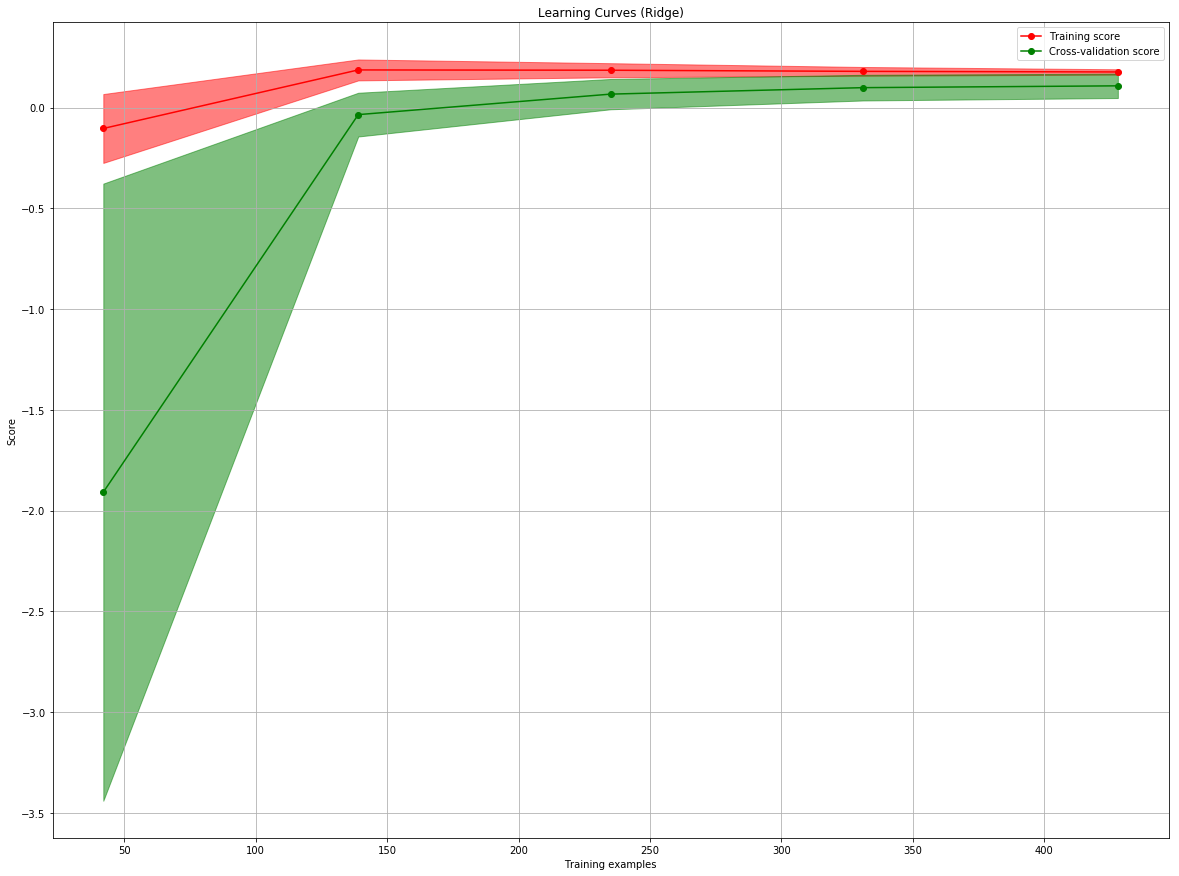

In [36]:
title = "Learning Curves (Ridge)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

plot_learning_curve(grid_search.best_estimator_, title, X_train, y_train[EMOSCORES[emotionid]],  cv=cv, n_jobs=-1)

plt.show()

In [37]:
######### LARS ########
lars_regr = Lars( fit_intercept = False)
lars_regr.fit(X_train.toarray(), y_train[EMOSCORES[emotionid]])

ytestLars_pred=lars_regr.predict(X_test)
ytrainLars_pred=lars_regr.predict(X_train)

print("Mean squared error wtd Lasso CV (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytestLars_pred,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd Lasso CV (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytestLars_pred,sample_weight=y_test[EMOWTS[emotionid]]))
lars_regr.alphas_

Mean squared error wtd Lasso CV (test): 18.62
Variance score wtd Lasso CV (test): 0.4720


array([ 6.29261383,  4.07062098,  3.87350976,  3.53263894,  3.49083739,
        2.96248478,  2.40539425,  2.30500208,  0.57903094,  0.55354082,
        0.5054205 ,  0.41234731,  0.27696678,  0.24386181,  0.17320816,
        0.15724898,  0.11493792,  0.        ])

In [38]:
bestEstimator_testmse = mean_squared_error( y_test[EMOSCORES[emotionid]],ytestLars_pred,sample_weight=y_test[EMOWTS[emotionid]])
bestEstimator_testr2 = r2_score( y_test[EMOSCORES[emotionid]],ytestLars_pred,sample_weight=y_test[EMOWTS[emotionid]])

bestEstimator_trainmse = mean_squared_error( y_train[EMOSCORES[emotionid]],ytrainLars_pred,sample_weight=y_train[EMOWTS[emotionid]])
bestEstimator_trainr2 = r2_score( y_train[EMOSCORES[emotionid]],ytrainLars_pred,sample_weight=y_train[EMOWTS[emotionid]])

save_info = pd.DataFrame()
regr_info = pd.Series(str(lars_regr.get_params()))

save_info['trained'] = regr_info
save_info['regressor name'] = "Lars"
save_info['test wtd mse'] = bestEstimator_testmse
save_info['test wtd r2'] = bestEstimator_testr2
save_info['train wtd mse'] = bestEstimator_trainmse
save_info['train wtd r2'] = bestEstimator_trainr2
save_info['emotion'] = "happy"

with open('C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\regressorExperiments.csv', 'a') as f:
    save_info.to_csv(f, header=False, index=False)